In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.append("../")

from scipy.optimize import curve_fit
from src.enablence_mux import EBMUX

In [2]:
target_grid_array = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9 

wavelength_fabrication = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9

In [3]:
sppd_mc_data = xr.open_dataset("../simulation_data/sppd_clm_controller_montecarlo_spec_v0p5_20240509_0p1.nc")

In [4]:
sppd_mc_data

<xarray.Dataset>
Dimensions:                      (idd_iter: 251, idd_laser: 16, idd_eb: 1,
                                  idd_sppd: 1, idd_wpe: 1, observable_stat: 16,
                                  controller_observable: 5, lin_sweep_range: 2,
                                  idd_mux: 1, idd_bw_lambda: 1)
Coordinates:
  * idd_iter                     (idd_iter) int32 0 1 2 3 4 ... 247 248 249 250
  * observable_stat              (observable_stat) object 'std' ... 'min_agg_2'
  * idd_laser                    (idd_laser) int32 0 1 2 3 4 ... 11 12 13 14 15
  * controller_observable        (controller_observable) object 'drive_curren...
  * lin_sweep_range              (lin_sweep_range) float64 0.1 0.2
  * idd_mux                      (idd_mux) int32 0
  * idd_eb                       (idd_eb) int32 0
  * idd_sppd                     (idd_sppd) int32 0
  * idd_bw_lambda                (idd_bw_lambda) int32 0
  * idd_wpe                      (idd_wpe) int32 0
Data variables:
    enablence_mux_mc             (idd_iter, idd_laser, idd_eb) float64 ...
    sppd_laser_mc                (idd_iter, idd_laser, idd_sppd) float64 ...
    wpe_slope_factor_mc          (idd_iter, idd_laser, idd_wpe) float64 ...
    dfb_backside_temperature_mc  (idd_iter) float64 ...
    data_statistics_array        (idd_mux, idd_iter, idd_eb, idd_sppd, idd_bw_lambda, idd_wpe, lin_sweep_range, controller_observable, observable_stat, idd_laser) float64 ...
Attributes:
    description:  SPPD CLM Controller Monte Carlo Simulation simulations - da...

In [5]:
enablence_mux_bw_lambda = np.array([20])/17*0.1e-9
enablence_mux_3sigma = np.array([17])/17*0.1e-9
sppd_laser_3sigma = np.array([27])/17*0.1e-9
no_mux = np.array([0])
wpe_slope_3sigma = np.array([0.15])
lin_sweep_val_range = np.array([0.1, 0.2])
mpd_current_clamp_range = np.array([40e-3])

no_lasers = 16
no_iterations = 201

no_bins = 41

In [6]:
def gaussian_quality(x_data, no_bins):
    hist, bin_edges = np.histogram(x_data, bins = no_bins)
    hist = hist/sum(hist)
    n = len(hist)
    x_hist=np.zeros((n),dtype=float) 
    for ii in range(n):
        x_hist[ii]=(bin_edges[ii+1]+bin_edges[ii])/2
    y_hist=hist

    def gaus(X,C,X_mean,sigma):
        return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

    mean = sum(x_hist*y_hist)/sum(y_hist)                  
    sigma = sum(y_hist*(x_hist-mean)**2)/sum(y_hist) 

    #Gaussian least-square fitting process
    param_optimised,_ = curve_fit(gaus,x_hist,y_hist,p0=[max(y_hist),mean,sigma],maxfev=5000)    

    x_hist_2 = np.linspace(np.min(x_hist),np.max(x_hist),500)
    
    y_hist_2 = gaus(x_hist_2,*param_optimised) 
    return param_optimised, x_hist_2, y_hist_2

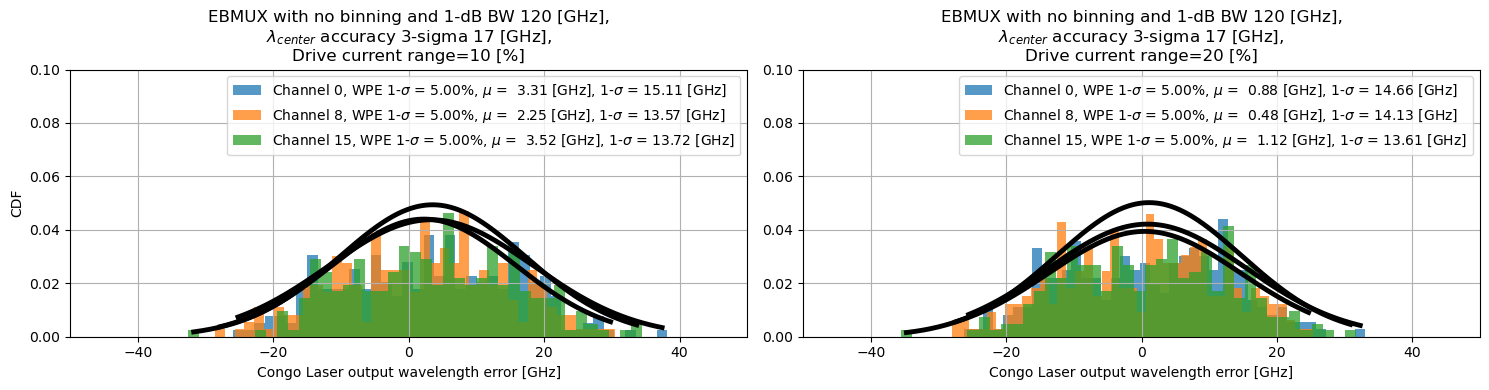

In [7]:
stat_attribute_combo = [""]
stat_attribute_title = ["Including all aggressors"]
plt.figure(figsize=(15,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(1):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            lambda_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'enablence_output_lambda').values
            param_optimised, x_hist, y_hist = gaussian_quality((lambda_ch - target_grid_array[idd_laser_updated])*1e9/0.1*17, no_bins)
            median_lamda_ch = np.abs(param_optimised[1])
            std_lamda_ch = np.abs(param_optimised[2])
            plt.hist((lambda_ch - target_grid_array[idd_laser_updated])*1e9/0.1*17, linewidth=3.5, alpha = 0.75, bins=no_bins, density = True, label=f'Channel {idd_laser_updated},'+r' WPE 1-$\sigma$ = '+f'{wpe_slope_3sigma[idd_wpe]*100/3:0.2f}%'+r', $\mu$ = '+f' {np.abs(median_lamda_ch):0.2f} [GHz], '+f'1-$\sigma$ = '+f'{std_lamda_ch:0.2f} [GHz]')
            plt.plot(x_hist, y_hist, linewidth=3.5, color='k')
            plt.legend()
            plt.xlim([-50, 50])
            plt.ylim([0, 0.10])
            plt.grid(True)
            plt.title(f'EBMUX with no binning and 1-dB BW 120 [GHz],\n'+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%]')
            if idd_stat == len(stat_attribute_combo) - 1:
              plt.xlabel('Congo Laser output wavelength error [GHz]')
            if idd_lin_sweep_val_range == 0:
              plt.ylabel('CDF')
plt.tight_layout()

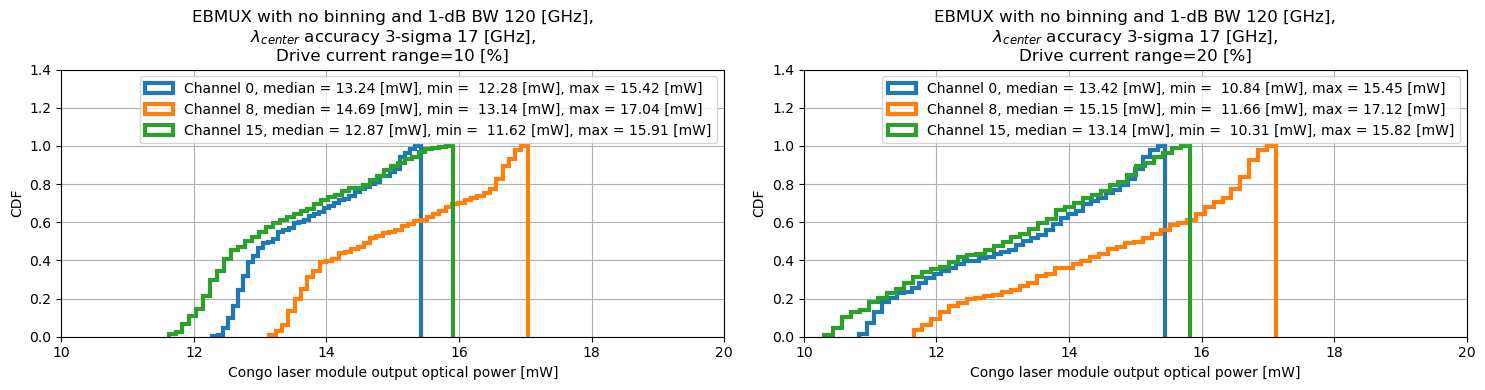

In [8]:
plt.figure(figsize=(15,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            pout_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'enablence_output_power').values*1e3
            median_pout_ch = np.median(pout_ch)
            min_pout_ch = np.min(pout_ch)
            max_pout_ch = np.max(pout_ch)
            plt.hist(pout_ch, density = True, cumulative= True, linewidth=3.0, histtype= 'step', bins=no_bins, label=f'Channel {idd_laser_updated},'+r' median = '+f'{median_pout_ch:0.2f} [mW]'+r', min = '+f' {(min_pout_ch):0.2f} [mW], '+f'max = '+f'{max_pout_ch:0.2f} [mW]')
            plt.legend()
            plt.xlim([10, 20])
            plt.ylim([0,1.4])
            plt.grid(True)
            plt.title(f'EBMUX with no binning and 1-dB BW 120 [GHz],\n'+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%]')
            plt.xlabel('Congo laser module output optical power [mW]')
            plt.ylabel('CDF')
plt.tight_layout()

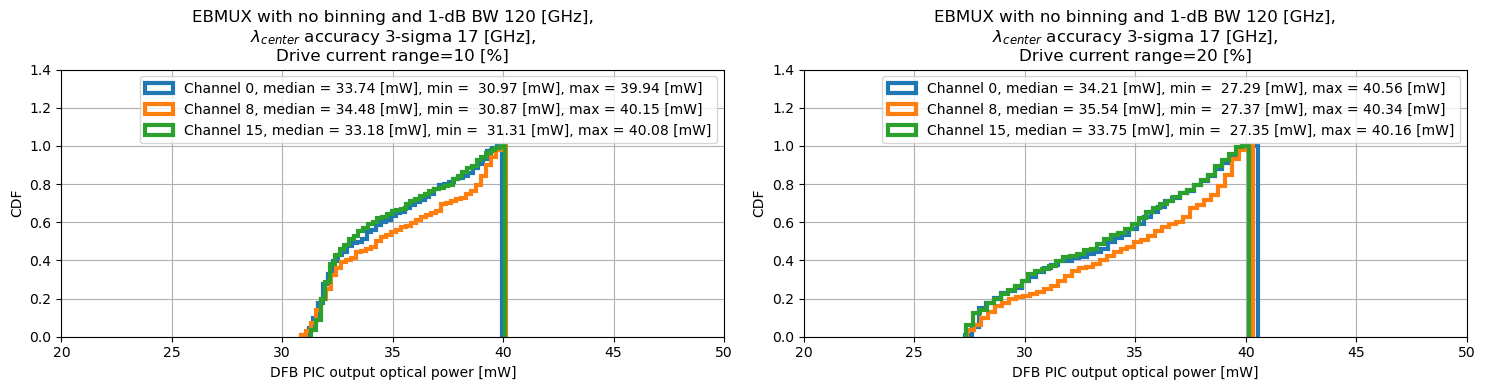

In [9]:
plt.figure(figsize=(15,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            pout_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'sppd_pout').values*1e3
            median_pout_ch = np.median(pout_ch)
            min_pout_ch = np.min(pout_ch)
            max_pout_ch = np.max(pout_ch)
            plt.hist(pout_ch, density = True, cumulative= True, linewidth=3.0, histtype= 'step', bins=no_bins, label=f'Channel {idd_laser_updated},'+r' median = '+f'{median_pout_ch:0.2f} [mW]'+r', min = '+f' {(min_pout_ch):0.2f} [mW], '+f'max = '+f'{max_pout_ch:0.2f} [mW]')
            plt.legend()
            plt.xlim([20, 50])
            plt.ylim([0,1.4])
            plt.grid(True)
            plt.title(f'EBMUX with no binning and 1-dB BW 120 [GHz],\n'+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%]')
            plt.xlabel('DFB PIC output optical power [mW]')
            plt.ylabel('CDF')
plt.tight_layout()

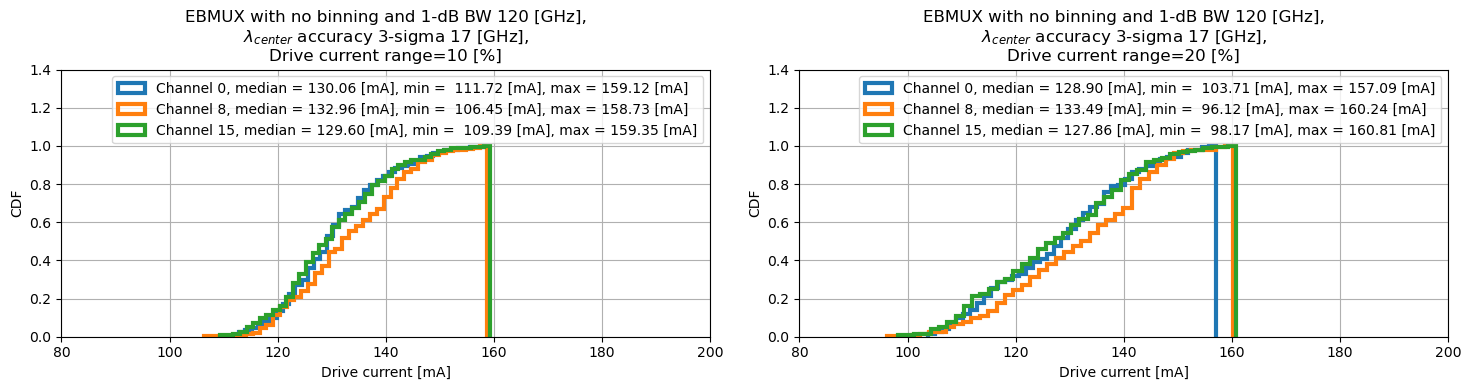

In [10]:
plt.figure(figsize=(15,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            idrive_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'drive_current').values*1e3
            median_idrive_ch = np.median(idrive_ch)
            min_idrive_ch = np.min(idrive_ch)
            max_idrive_ch = np.max(idrive_ch)
            plt.hist(idrive_ch, density = True, cumulative= True, linewidth=3.0, histtype= 'step', bins=no_bins, label=f'Channel {idd_laser_updated},'+r' median = '+f'{median_idrive_ch:0.2f} [mA]'+r', min = '+f' {(min_idrive_ch):0.2f} [mA], '+f'max = '+f'{max_idrive_ch:0.2f} [mA]')
            plt.legend()
            plt.xlim([80, 200])
            plt.ylim([0,1.4])
            plt.grid(True)
            plt.title(f'EBMUX with no binning and 1-dB BW 120 [GHz],\n'+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%]')
            plt.xlabel('Drive current [mA]')
            plt.ylabel('CDF')
plt.tight_layout()

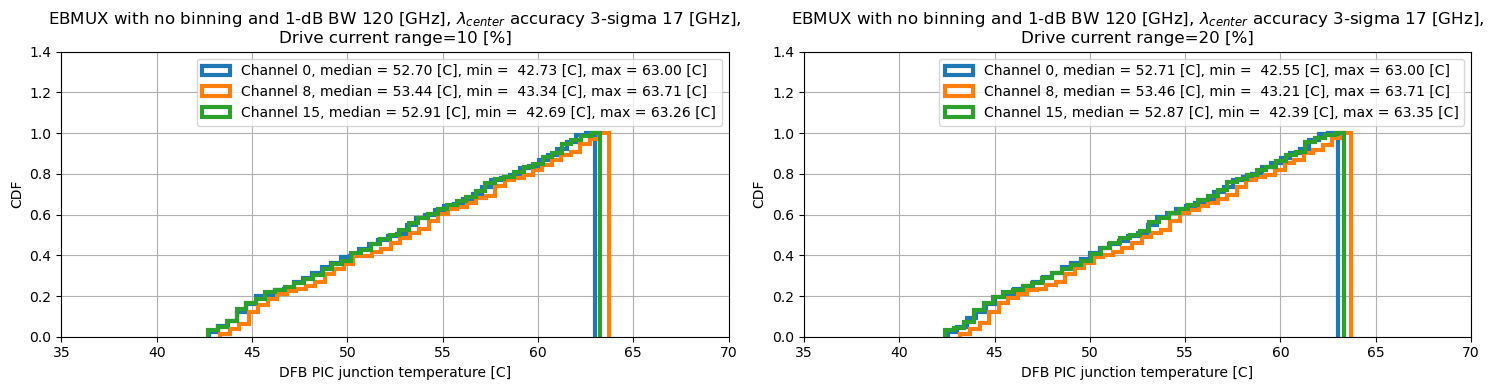

In [11]:
plt.figure(figsize=(15,4*len(stat_attribute_combo)))
for idd_mux in no_mux:
  for idd_laser in range(3):
    for idd_bw_lambda in range(len(enablence_mux_bw_lambda)):
      for idd_wpe in range(len(wpe_slope_3sigma)):
        for idd_lin_sweep_val_range in range(len(lin_sweep_val_range)):
          for idd_stat, stat_value in enumerate(stat_attribute_combo):
            plt.subplot(len(stat_attribute_combo), len(lin_sweep_val_range), idd_stat*len(lin_sweep_val_range) + idd_lin_sweep_val_range+1)  
            idd_laser_updated = idd_laser * 8
            if idd_laser == 2:
              idd_laser_updated = idd_laser * 8 - 1
            pic_jc_ch = sppd_mc_data['data_statistics_array'].sel(idd_eb = 0, idd_sppd = 0, idd_bw_lambda = idd_bw_lambda, idd_laser=idd_laser_updated, idd_mux=idd_mux, idd_wpe=idd_wpe, lin_sweep_range = lin_sweep_val_range[idd_lin_sweep_val_range],  observable_stat = 'mean'+stat_value, controller_observable = 'sppd_laser_junction_temperature').values-273.15
            median_pic_jc_ch = np.median(pic_jc_ch)
            min_pic_jc_ch = np.min(pic_jc_ch)
            max_pic_jc_ch = np.max(pic_jc_ch)
            plt.hist(pic_jc_ch, density = True, cumulative= True, linewidth=3.0, histtype= 'step', bins=no_bins, label=f'Channel {idd_laser_updated},'+r' median = '+f'{median_pic_jc_ch:0.2f} [C]'+r', min = '+f' {(min_pic_jc_ch):0.2f} [C], '+f'max = '+f'{max_pic_jc_ch:0.2f} [C]')
            plt.legend()
            plt.xlim([35, 70])
            plt.ylim([0,1.4])
            plt.grid(True)
            plt.title(f'EBMUX with no binning and 1-dB BW 120 [GHz], '+r'$\lambda_{center}$ accuracy'+' 3-sigma 17 [GHz],\nDrive current range'+f'={lin_sweep_val_range[idd_lin_sweep_val_range]*100:0.0f} [%]')
            plt.xlabel('DFB PIC junction temperature [C]')
            plt.ylabel('CDF')
plt.tight_layout()